# Custom car environment
## Solved using Q learning and Decision trees (LightGBM)

#### References
Inspiration for this project:
- https://towardsdatascience.com/reinforcement-learning-q-learning-with-decision-trees-ecb1215d9131
- https://www.semanticscholar.org/paper/Reinforcement-Learning-with-Decision-Trees-Pyeatt/f9b30e1f6d85cb77e95ff1d580ee67d7406f1dd6?p2df

Helper functions to calculate intercept point in PyGame:
- https://www.codeproject.com/Tips/864704/Python-Line-Intersection-for-Pygame

In [26]:
import pygame
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.ensemble
import sklearn.tree
from sklearn.exceptions import NotFittedError
from lightgbm import LGBMRegressor
import sklearn.multioutput
from collections import deque
import random
from math import sqrt
import timeit

BLACK = (0, 0, 0)
WHITE = (255, 255, 255)
RED = (255,0,0)
GREEN = (0,255,0)
BLUE = (0,0,255)

MAP_POINTS = [(0,100), (50,300), (10,400),(60,500), (200,560),
              (400,500),(500,400),(600,350),(700,325),
              (800,315),(900,800),(1100,800),(1000,600),
              (950,500),(975,400),(850,150),(500,300),
              (350,375),(250,410),(175,375),(120,350),(100,0)
             ]

#helpers
def slope(p1, p2) :
    return (p2[1] - p1[1]) * 1. / ((p2[0] - p1[0])+1e-5)
   
def y_intercept(slope, p1) :
    return p1[1] - 1. * slope * p1[0]
   
def intersect_p(line1, line2) :
    min_allowed = 1e-5
    big_value = 1e10
    m1 = slope(line1[0], line1[1])
    b1 = y_intercept(m1, line1[0])
    m2 = slope(line2[0], line2[1])
    b2 = y_intercept(m2, line2[0])
    if abs(m1 - m2) < min_allowed :
        x = big_value
    else :
        x = (b2 - b1) / (m1 - m2)
    y = m1 * x + b1
    y2 = m2 * x + b2
    return (int(x),int(y))

def segment_intersect(line1, line2) :
    intersection_pt = intersect_p(line1, line2)
    
    if (line1[0][0] < line1[1][0]) :
        if intersection_pt[0] < line1[0][0] or intersection_pt[0] > line1[1][0] :
            return None
    else :
        if intersection_pt[0] > line1[0][0] or intersection_pt[0] < line1[1][0] :
            return None
         
    if (line2[0][0] < line2[1][0]) :
        if intersection_pt[0] < line2[0][0] or intersection_pt[0] > line2[1][0] :
            return None
    else :
        if intersection_pt[0] > line2[0][0] or intersection_pt[0] < line2[1][0] :
            return None

    return intersection_pt

class Car():
    def __init__(self):
        self.center_pos = pygame.math.Vector2(50, 50)
        self.corners = [
            pygame.math.Vector2(-10,-20),
            pygame.math.Vector2(10,-20),
            pygame.math.Vector2(10,20),
            pygame.math.Vector2(-10,20)
        ]
        self.corners_pos = [x+self.center_pos for x in self.corners]
        self.sensors = [
            pygame.math.Vector2(0,1000),
            pygame.math.Vector2(966,258),
            pygame.math.Vector2(-966,258)
        ]
        self.sensors_pos = [x+self.center_pos for x in self.sensors]
        self.velocity = pygame.math.Vector2(0,10)
        self.angle = 0
        self.intersects = []
        self.signals = [0, 0, 0]
        
    def update(self, action):
       ##### next_state, reward, done
        angleChange = 10
        if action == 0: 
            angleChange = -10
        elif action == 1:
            angleChange = 0
        
        self.angle += angleChange
        self.angle = self.angle % 360
        self.center_pos = self.center_pos + self.velocity.rotate(self.angle)
        self.corners_pos = [x.rotate(self.angle)+self.center_pos for x in self.corners]
        self.sensors_pos = [x.rotate(self.angle)+self.center_pos for x in self.sensors]
        self.intersects = []
        self.signals = []
        for sensor in self.sensors_pos:
            sensor_intersects = []
            for i in range(len(MAP_POINTS)-1):
                intersect = segment_intersect([MAP_POINTS[i],MAP_POINTS[i+1]],[(self.center_pos.x,self.center_pos.y),(sensor.x,sensor.y)])
                if(intersect != None):
                    sensor_intersects.append(intersect)        
            if len(sensor_intersects) == 0:
                self.intersects.append((-100,-100))
                self.signals.append(1000)
            else:
                sensor_distances = [sqrt((x[0] - self.center_pos.x)**2 +(x[1] - self.center_pos.y)**2) for x in sensor_intersects]
                self.intersects.append(sensor_intersects[sensor_distances.index(min(sensor_distances))])
                self.signals.append(min(sensor_distances))
        
        #check car colision
        reward = 1
        reset = False
        for signal in self.signals:
            #Reset if hit a wall
            if signal < 15:
                self.reset()
                reset = True
                reward = -1
                break
            #Reset if out of map (this is a small bug in our simulation, which does not happen often)
            if self.center_pos.x < 0 or self.center_pos.x > 1000 or self.center_pos.y < 0 or self.center_pos.y > 700:
                self.reset()
                reset = True
                reward = 0
                break
            #Reset if reached goal
            if self.center_pos.x > 925 and self.center_pos.y > 625:
                self.reset()
                reset = True
                #set reward to 2 so that we know env has been solved
                reward = 2
                break
                
        next_state = []        
        for signal in self.signals:
            next_state.append(signal)
        next_state.append(self.angle)
        
        return np.array(next_state), reward, reset
                
    #reset car position
    def reset(self):
        self.__init__()

In [27]:
class Treepredictor():
    def __init__(self,input_shape,output_shape,exploration_min = 0.01, exploration_decay = 0.996,
                 exploration_rate = 1, batch_size = 32, gamma = 0.95, lr=0.001):
        
        #models hyperparameters
        self.exploration_min = exploration_min
        self.exploration_decay = exploration_decay
        self.exploration_rate = exploration_rate
        self.batch_size = batch_size
        self.gamma = gamma
        self.lr = lr
        
        #model architecture
        self.forest = sklearn.ensemble.GradientBoostingRegressor(n_estimators=100,random_state=0)
        self.regressor = sklearn.multioutput.MultiOutputRegressor(self.forest)
        
        self.memory = deque(maxlen=2000)
        
    def select_action(self,state):
        if np.random.rand() < self.exploration_rate:
            action = random.randint(0,2)
            return action
        try:
            q_values = self.regressor.predict(state.reshape(1, -1))
            return np.argmax(q_values)
        except NotFittedError as e:
            return 0

    def remember(self,last_state,action,reward,next_state,done):
        self.memory.append((last_state,action,reward,next_state,done))
    
    def experience_replay(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory
        
        X = np.empty((0,4))
        y = np.empty((0,3))
        for last_state, action, reward, next_state, done in batch:
            q_update = reward
            if not done:
                try:
                    q_update = (reward + self.gamma * np.amax(self.regressor.predict(np.array(next_state, dtype=np.float32).reshape(1, -1))))
                except NotFittedError as e:
                    q_update = reward 
            try:
                q_values = self.regressor.predict(np.array(last_state, dtype=np.float32).reshape(1, -1))
            except NotFittedError as e:
                q_values = np.zeros(3, dtype=np.float32).reshape(1, -1)
            q_values[0][action] = q_update

            X = np.append(X,np.array([last_state]),axis=0)
            y = np.append(y,np.array([q_values[0]]),axis=0)

        #fit
        self.regressor.fit(X,y)

        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.exploration_decay

In [28]:
class MetricsLogger():
    
    def __init__(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])
        self.runs_logs = np.empty((0,3))
        
    def reset_run(self):
        self.episodes_steps = np.array([])
        self.episodes_before_solve = np.array([])

logs = MetricsLogger()

In [29]:
pygame.init()
 
screen = pygame.display.set_mode([1000, 700])
 
pygame.display.set_caption('Comp 432 custom car env - Q learning NN')

car = Car()
clock = pygame.time.Clock()
exit = False
done = False
for run_i in range(5):
    if exit:
        break
    
    start = timeit.default_timer()
    num_solved = 0
    episode_i = 0
    episode_i_before_solve = 0
    logs.reset_run()
    
    #Init model
    model = Treepredictor(4,3)
    
    while num_solved < 5 and episode_i < 2000:
        if exit:
            break
        episode_i += 1
        car.reset()
        last_state = np.array([1000, 1000, 1000, 0])
        steps = 0
        total_reward = 0
        episode_i_before_solve += 1
        
        while True:
            #allow for exit with X on window
            for event in pygame.event.get():
                if event.type == pygame.QUIT:
                    exit = True
                    break
            # -- Draw everything
            # Clear screen
            screen.fill(BLACK)

            #draw map
            pygame.draw.lines(screen,WHITE,False,MAP_POINTS)

            #draw goal
            pygame.draw.circle(screen,GREEN,(950,650),20)

            #draw car
            pygame.draw.lines(screen,WHITE,True,[(vect.x,vect.y) for vect in car.corners_pos])


            #draw sensors
            for sensor in car.sensors_pos:
                pygame.draw.line(screen,GREEN,(car.center_pos.x,car.center_pos.y),(sensor.x,sensor.y))   

            for intersect in car.intersects:
                pygame.draw.circle(screen,RED,intersect,5)

            pygame.display.flip()
            clock.tick(120)

            steps += 1
            
            action = model.select_action(last_state)
            next_state, reward, done = car.update(action)
            model.remember(last_state,action,reward,next_state,done)

            total_reward += reward

            if done:
                print("Episode {} finished after {} steps with {} total reward".format(episode_i,steps,total_reward))
                if reward == 2:
                    print("reached goal")
                    logs.episodes_before_solve = np.append(logs.episodes_before_solve,episode_i_before_solve)
                    episode_i_before_solve = 0
                    num_solved += 1
                break

            last_state = next_state
        
        model.experience_replay()
        logs.episodes_steps = np.append(logs.episodes_steps,steps)

    stop = timeit.default_timer()
    print("Run {} done in {}".format(run_i,stop - start))
    
    logs.runs_logs = np.append(logs.runs_logs,[[logs.episodes_steps,logs.episodes_before_solve,stop - start]],axis=0)
    
pygame.quit()

Episode 1 finished after 11 steps with 9 total reward
Episode 2 finished after 22 steps with 20 total reward
Episode 3 finished after 11 steps with 9 total reward
Episode 4 finished after 13 steps with 11 total reward
Episode 5 finished after 8 steps with 6 total reward
Episode 6 finished after 10 steps with 8 total reward
Episode 7 finished after 20 steps with 18 total reward
Episode 8 finished after 11 steps with 9 total reward
Episode 9 finished after 12 steps with 10 total reward
Episode 10 finished after 10 steps with 8 total reward
Episode 11 finished after 19 steps with 17 total reward
Episode 12 finished after 13 steps with 11 total reward
Episode 13 finished after 16 steps with 14 total reward
Episode 14 finished after 21 steps with 19 total reward
Episode 15 finished after 14 steps with 12 total reward
Episode 16 finished after 18 steps with 16 total reward
Episode 17 finished after 19 steps with 17 total reward
Episode 18 finished after 21 steps with 19 total reward
Episode 

Episode 148 finished after 58 steps with 56 total reward
Episode 149 finished after 19 steps with 17 total reward
Episode 150 finished after 80 steps with 78 total reward
Episode 151 finished after 81 steps with 79 total reward
Episode 152 finished after 79 steps with 77 total reward
Episode 153 finished after 13 steps with 11 total reward
Episode 154 finished after 47 steps with 45 total reward
Episode 155 finished after 49 steps with 47 total reward
Episode 156 finished after 77 steps with 75 total reward
Episode 157 finished after 15 steps with 13 total reward
Episode 158 finished after 86 steps with 84 total reward
Episode 159 finished after 15 steps with 13 total reward
Episode 160 finished after 75 steps with 73 total reward
Episode 161 finished after 21 steps with 19 total reward
Episode 162 finished after 132 steps with 130 total reward
Episode 163 finished after 25 steps with 23 total reward
Episode 164 finished after 76 steps with 74 total reward
Episode 165 finished after 89

Episode 292 finished after 55 steps with 53 total reward
Episode 293 finished after 14 steps with 12 total reward
Episode 294 finished after 44 steps with 42 total reward
Episode 295 finished after 47 steps with 45 total reward
Episode 296 finished after 58 steps with 56 total reward
Episode 297 finished after 57 steps with 55 total reward
Episode 298 finished after 89 steps with 87 total reward
Episode 299 finished after 23 steps with 21 total reward
Episode 300 finished after 11 steps with 9 total reward
Episode 301 finished after 68 steps with 66 total reward
Episode 302 finished after 27 steps with 25 total reward
Episode 303 finished after 15 steps with 13 total reward
Episode 304 finished after 86 steps with 84 total reward
Episode 305 finished after 52 steps with 50 total reward
Episode 306 finished after 177 steps with 178 total reward
reached goal
Episode 307 finished after 57 steps with 55 total reward
Episode 308 finished after 47 steps with 45 total reward
Episode 309 finis

Episode 66 finished after 47 steps with 45 total reward
Episode 67 finished after 51 steps with 49 total reward
Episode 68 finished after 27 steps with 25 total reward
Episode 69 finished after 15 steps with 13 total reward
Episode 70 finished after 14 steps with 12 total reward
Episode 71 finished after 40 steps with 38 total reward
Episode 72 finished after 18 steps with 16 total reward
Episode 73 finished after 22 steps with 20 total reward
Episode 74 finished after 10 steps with 8 total reward
Episode 75 finished after 41 steps with 39 total reward
Episode 76 finished after 14 steps with 12 total reward
Episode 77 finished after 17 steps with 15 total reward
Episode 78 finished after 13 steps with 11 total reward
Episode 79 finished after 24 steps with 22 total reward
Episode 80 finished after 46 steps with 44 total reward
Episode 81 finished after 32 steps with 30 total reward
Episode 82 finished after 12 steps with 10 total reward
Episode 83 finished after 47 steps with 45 total 

Episode 211 finished after 30 steps with 28 total reward
Episode 212 finished after 45 steps with 43 total reward
Episode 213 finished after 17 steps with 15 total reward
Episode 214 finished after 12 steps with 10 total reward
Episode 215 finished after 33 steps with 31 total reward
Episode 216 finished after 78 steps with 76 total reward
Episode 217 finished after 48 steps with 46 total reward
Episode 218 finished after 46 steps with 44 total reward
Episode 219 finished after 46 steps with 44 total reward
Episode 220 finished after 46 steps with 44 total reward
Episode 221 finished after 13 steps with 11 total reward
Episode 222 finished after 51 steps with 49 total reward
Episode 223 finished after 18 steps with 16 total reward
Episode 224 finished after 46 steps with 44 total reward
Episode 225 finished after 15 steps with 13 total reward
Episode 226 finished after 17 steps with 15 total reward
Episode 227 finished after 29 steps with 27 total reward
Episode 228 finished after 15 s

Episode 354 finished after 45 steps with 43 total reward
Episode 355 finished after 45 steps with 43 total reward
Episode 356 finished after 46 steps with 44 total reward
Episode 357 finished after 14 steps with 12 total reward
Episode 358 finished after 129 steps with 127 total reward
Episode 359 finished after 131 steps with 129 total reward
Episode 360 finished after 31 steps with 29 total reward
Episode 361 finished after 82 steps with 80 total reward
Episode 362 finished after 132 steps with 130 total reward
Episode 363 finished after 132 steps with 130 total reward
Episode 364 finished after 46 steps with 44 total reward
Episode 365 finished after 129 steps with 127 total reward
Episode 366 finished after 31 steps with 29 total reward
Episode 367 finished after 79 steps with 77 total reward
Episode 368 finished after 47 steps with 45 total reward
Episode 369 finished after 126 steps with 124 total reward
Episode 370 finished after 24 steps with 22 total reward
Episode 371 finishe

Episode 72 finished after 10 steps with 8 total reward
Episode 73 finished after 55 steps with 53 total reward
Episode 74 finished after 10 steps with 8 total reward
Episode 75 finished after 22 steps with 20 total reward
Episode 76 finished after 16 steps with 14 total reward
Episode 77 finished after 18 steps with 16 total reward
Episode 78 finished after 12 steps with 10 total reward
Episode 79 finished after 23 steps with 21 total reward
Episode 80 finished after 56 steps with 54 total reward
Episode 81 finished after 28 steps with 26 total reward
Episode 82 finished after 11 steps with 9 total reward
Episode 83 finished after 22 steps with 20 total reward
Episode 84 finished after 14 steps with 12 total reward
Episode 85 finished after 14 steps with 12 total reward
Episode 86 finished after 10 steps with 8 total reward
Episode 87 finished after 33 steps with 31 total reward
Episode 88 finished after 43 steps with 41 total reward
Episode 89 finished after 23 steps with 21 total rew

Episode 217 finished after 51 steps with 49 total reward
Episode 218 finished after 56 steps with 54 total reward
Episode 219 finished after 47 steps with 45 total reward
Episode 220 finished after 57 steps with 55 total reward
Episode 221 finished after 50 steps with 48 total reward
Episode 222 finished after 16 steps with 14 total reward
Episode 223 finished after 50 steps with 48 total reward
Episode 224 finished after 64 steps with 62 total reward
Episode 225 finished after 55 steps with 53 total reward
Episode 226 finished after 91 steps with 89 total reward
Episode 227 finished after 17 steps with 15 total reward
Episode 228 finished after 97 steps with 95 total reward
Episode 229 finished after 26 steps with 24 total reward
Episode 230 finished after 30 steps with 28 total reward
Episode 231 finished after 30 steps with 28 total reward
Episode 232 finished after 59 steps with 57 total reward
Episode 233 finished after 25 steps with 23 total reward
Episode 234 finished after 26 s

Episode 4 finished after 32 steps with 30 total reward
Episode 5 finished after 12 steps with 10 total reward
Episode 6 finished after 22 steps with 20 total reward
Episode 7 finished after 9 steps with 7 total reward
Episode 8 finished after 24 steps with 22 total reward
Episode 9 finished after 20 steps with 18 total reward
Episode 10 finished after 18 steps with 16 total reward
Episode 11 finished after 30 steps with 28 total reward
Episode 12 finished after 14 steps with 12 total reward
Episode 13 finished after 18 steps with 16 total reward
Episode 14 finished after 12 steps with 10 total reward
Episode 15 finished after 24 steps with 22 total reward
Episode 16 finished after 12 steps with 10 total reward
Episode 17 finished after 9 steps with 7 total reward
Episode 18 finished after 12 steps with 10 total reward
Episode 19 finished after 11 steps with 9 total reward
Episode 20 finished after 15 steps with 13 total reward
Episode 21 finished after 16 steps with 14 total reward
Epi

Episode 150 finished after 16 steps with 14 total reward
Episode 151 finished after 20 steps with 18 total reward
Episode 152 finished after 49 steps with 47 total reward
Episode 153 finished after 46 steps with 44 total reward
Episode 154 finished after 56 steps with 54 total reward
Episode 155 finished after 23 steps with 21 total reward
Episode 156 finished after 62 steps with 60 total reward
Episode 157 finished after 24 steps with 22 total reward
Episode 158 finished after 10 steps with 8 total reward
Episode 159 finished after 57 steps with 55 total reward
Episode 160 finished after 25 steps with 23 total reward
Episode 161 finished after 25 steps with 23 total reward
Episode 162 finished after 15 steps with 13 total reward
Episode 163 finished after 98 steps with 96 total reward
Episode 164 finished after 81 steps with 79 total reward
Episode 165 finished after 23 steps with 21 total reward
Episode 166 finished after 133 steps with 131 total reward
Episode 167 finished after 44 

Episode 294 finished after 92 steps with 90 total reward
Episode 295 finished after 170 steps with 171 total reward
reached goal
Episode 296 finished after 161 steps with 162 total reward
reached goal
Episode 297 finished after 95 steps with 93 total reward
Episode 298 finished after 105 steps with 103 total reward
Episode 299 finished after 167 steps with 168 total reward
reached goal
Episode 300 finished after 47 steps with 45 total reward
Episode 301 finished after 44 steps with 42 total reward
Episode 302 finished after 47 steps with 45 total reward
Episode 303 finished after 10 steps with 8 total reward
Episode 304 finished after 15 steps with 13 total reward
Episode 305 finished after 17 steps with 15 total reward
Episode 306 finished after 27 steps with 25 total reward
Episode 307 finished after 42 steps with 40 total reward
Episode 308 finished after 43 steps with 41 total reward
Episode 309 finished after 56 steps with 54 total reward
Episode 310 finished after 26 steps with 2

Episode 80 finished after 23 steps with 21 total reward
Episode 81 finished after 25 steps with 23 total reward
Episode 82 finished after 19 steps with 17 total reward
Episode 83 finished after 47 steps with 45 total reward
Episode 84 finished after 41 steps with 39 total reward
Episode 85 finished after 47 steps with 45 total reward
Episode 86 finished after 48 steps with 46 total reward
Episode 87 finished after 21 steps with 19 total reward
Episode 88 finished after 46 steps with 44 total reward
Episode 89 finished after 23 steps with 21 total reward
Episode 90 finished after 23 steps with 21 total reward
Episode 91 finished after 46 steps with 44 total reward
Episode 92 finished after 14 steps with 12 total reward
Episode 93 finished after 42 steps with 40 total reward
Episode 94 finished after 15 steps with 13 total reward
Episode 95 finished after 17 steps with 15 total reward
Episode 96 finished after 46 steps with 44 total reward
Episode 97 finished after 11 steps with 9 total 

Episode 224 finished after 14 steps with 12 total reward
Episode 225 finished after 13 steps with 11 total reward
Episode 226 finished after 72 steps with 70 total reward
Episode 227 finished after 128 steps with 126 total reward
Episode 228 finished after 73 steps with 71 total reward
Episode 229 finished after 124 steps with 122 total reward
Episode 230 finished after 91 steps with 89 total reward
Episode 231 finished after 81 steps with 79 total reward
Episode 232 finished after 82 steps with 80 total reward
Episode 233 finished after 79 steps with 77 total reward
Episode 234 finished after 27 steps with 25 total reward
Episode 235 finished after 13 steps with 11 total reward
Episode 236 finished after 64 steps with 62 total reward
Episode 237 finished after 90 steps with 88 total reward
Episode 238 finished after 13 steps with 11 total reward
Episode 239 finished after 62 steps with 60 total reward
Episode 240 finished after 47 steps with 45 total reward
Episode 241 finished after 

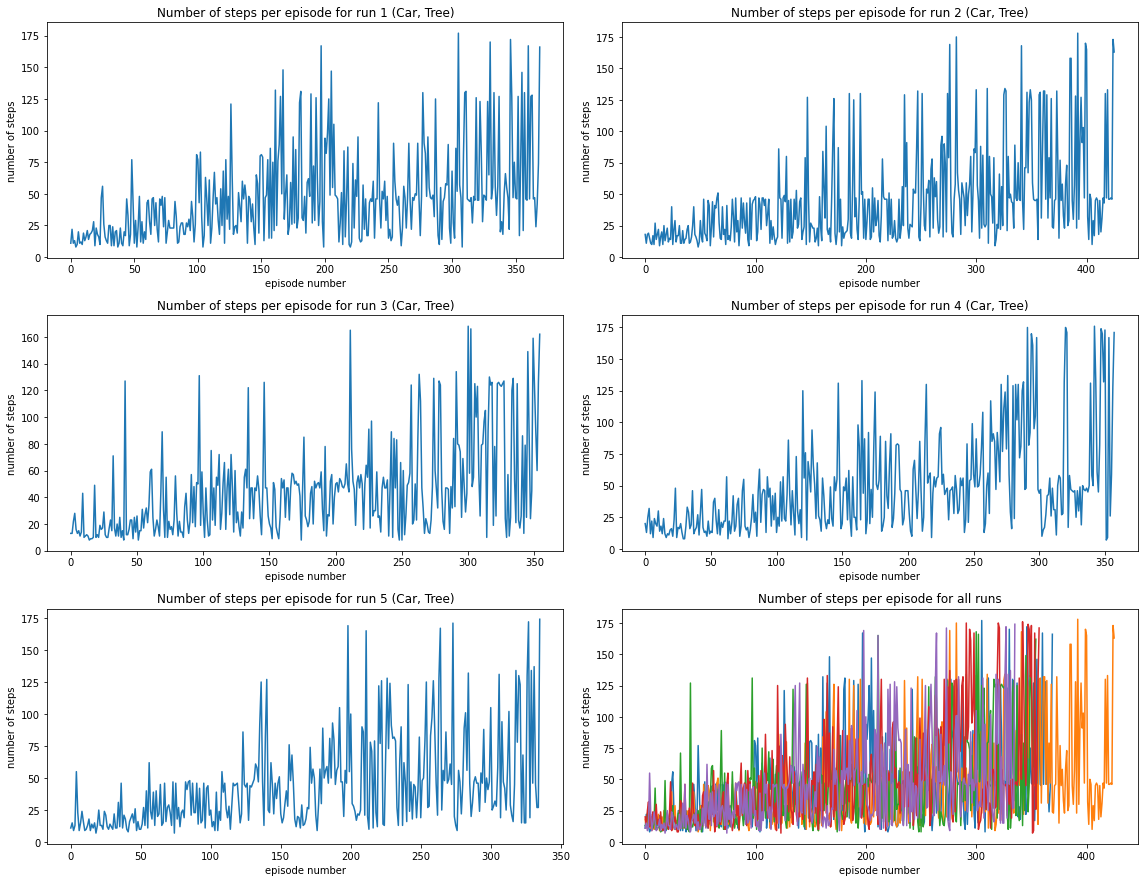

In [33]:
plt.figure(figsize=(16,16))
count = 0
for run_log in logs.runs_logs:
    count += 1
    plt.subplot(4,2,count,title="Number of steps per episode for run {} (Car, Tree)".format(count))
    plt.plot(run_log[0])
    plt.xlabel("episode number")
    plt.ylabel("number of steps")
    
plt.subplot(4,2,count+1,title="Number of steps per episode for all runs")
for run_log in logs.runs_logs:
    plt.plot(run_log[0])
plt.xlabel("episode number")
plt.ylabel("number of steps")
    
plt.tight_layout()
plt.show;

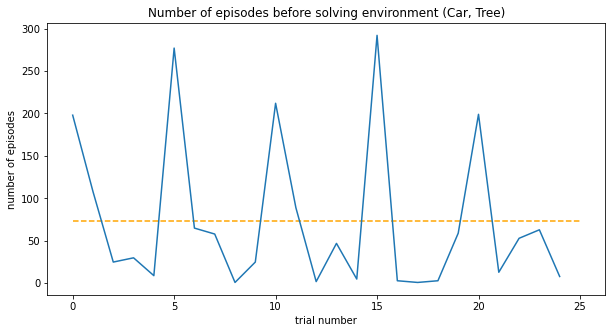

In [34]:
#####
# Everytime the env is solved, we look at the number of episodes it took before solving it.
# The peaks are at the start of each run, since the model is not yet trained.
####
cumul_episodes_before_solve = np.array([])
for run_log in logs.runs_logs:
    cumul_episodes_before_solve = np.append(cumul_episodes_before_solve,run_log[1])

average_episiodes_before_solve = np.sum(cumul_episodes_before_solve)/len(cumul_episodes_before_solve)

plt.figure(figsize=(10,5))
plt.plot(cumul_episodes_before_solve)
plt.hlines(average_episiodes_before_solve,0,25,linestyles="dashed",colors="orange")
plt.title("Number of episodes before solving environment (Car, Tree)")
plt.xlabel("trial number")
plt.ylabel("number of episodes")
plt.show;

In [32]:
cumul_steps_per_eps = np.array([])
cumul_time_per_run = np.array([])
for run_log in logs.runs_logs:
    cumul_steps_per_eps = np.append(cumul_steps_per_eps,run_log[0])
    cumul_time_per_run = np.append(cumul_time_per_run,run_log[2])

print("\nTotal number of steps per run:")
run_count = 0
for run_log in logs.runs_logs:
    run_count += 1
    print("\tRun {}, total steps : {}".format(run_count,np.sum(run_log[0])))

print("\nTotal number of steps: {}".format(np.sum(cumul_steps_per_eps)))
print("Average number of steps per run: {}".format(np.sum(cumul_steps_per_eps)/5))
print("\nAverage time per run: {} seconds".format(np.sum(cumul_time_per_run)/5))
print("Average time per step: {:.2f} seconds".format(np.sum(cumul_steps_per_eps)/np.sum(cumul_time_per_run)))


Total number of steps per run:
	Run 1, total steps : 17333.0
	Run 2, total steps : 19111.0
	Run 3, total steps : 16048.0
	Run 4, total steps : 17465.0
	Run 5, total steps : 14719.0

Total number of steps: 84676.0
Average number of steps per run: 16935.2

Average time per run: 1008.8889982000001 seconds
Average time per step: 16.79 seconds
